# US Accident Dataset 2016-2023

## Data Collection (Raw Data)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

#sklearn helpers/analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [5]:
#Some visualization settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-white')

/var/folders/6_/q20l7nsd6q93lk54vxqvb3x00000gn/T/ipykernel_46129/4092719186.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [10]:
df = pd.read_csv('US_Accidents_March23.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

There are a total of 45 data features in this dataset not including the index. Reporting this info will help us understand what features may be useful for our analysis. For example, we have a data frame for Start_Time and End_Time object types. From this we can actually expand the features to include the year, month, day, weekday, and hour of the accident.

### Expanding the Data (Time Duration)

In [12]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

timeduration = 'Time_Duration(td)'
df[timeduration]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
#Show these new columns added
df[['Start_Time','End_Time','Year','Month','Day','Hour','Weekday',timeduration]].head(5)

,Start_Time,End_Time,Year,Month,Day,Hour,Weekday,Time_Duration(TD)
0,2016-02-08 05:46:00,2016-02-08 11:00:00,2016.0,Feb,8.0,5.0,Mon,314.0
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2016.0,Feb,8.0,6.0,Mon,30.0
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2016.0,Feb,8.0,6.0,Mon,30.0
3,2016-02-08 07:23:34,2016-02-08 07:53:34,2016.0,Feb,8.0,7.0,Mon,30.0
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2016.0,Feb,8.0,7.0,Mon,30.0


Awesome now can move on to cleaning the data up and preparing it for analysis/training. First we will check for negative time durations and clean up any outliers.

In [20]:
x=0
if df[timeduration].isnull().values.any():
    x +=1
print(f'There are {x-1} records where Time_Duration is negative')
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident time: {} minutes.'.format(df[timeduration].max(),round(df[timeduration].max()/60), round(df[timeduration].max()/60/24), df[timeduration].min()))
print('The median time to clear an accident is {} minutes or {} hours.'.format(df[timeduration].median(),round(df[timeduration].median()/60)))
print('The average time to clear an accident is {} minutes or {} hours.'.format(round(df[timeduration].mean()),round(df[timeduration].mean()/60)))


There are 0 records where Time_Duration is negative
Max time to clear an accident: 2812939.0 minutes or 46882 hours or 1953 days; Min to clear an accident time: 1.0 minutes.
The median time to clear an accident is 63.0 minutes or 1 hours.
The average time to clear an accident is 427 minutes or 7 hours.


In [21]:
#Find outliers and replace with median
range=5
median = df[timeduration].median()
std = df[timeduration].std()
outliers = (df[timeduration] - median).abs() > std*range
df[outliers] = np.nan
df[timeduration].fillna(median, inplace=True)

/var/folders/6_/q20l7nsd6q93lk54vxqvb3x00000gn/T/ipykernel_46129/1380957436.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df[outliers] = np.nan


In [22]:
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident time: {} minutes.'.format(df[timeduration].max(),round(df[timeduration].max()/60), round(df[timeduration].max()/60/24), df[timeduration].min()))
print('The median time to clear an accident is {} minutes or {} hours.'.format(df[timeduration].median(),round(df[timeduration].median()/60)))
print('The average time to clear an accident is {} minutes or {} hours.'.format(round(df[timeduration].mean()),round(df[timeduration].mean()/60)))

Max time to clear an accident: 66263.0 minutes or 1104 hours or 46 days; Min to clear an accident time: 1.0 minutes.
The median time to clear an accident is 63.0 minutes or 1 hours.
The average time to clear an accident is 113 minutes or 2 hours.


### Label Encoding

In [27]:
string_columns = df.select_dtypes(include=['object'])
string_column_names = string_columns.columns.tolist()
le = LabelEncoder()
for column in string_column_names:
    df[column]=le.fit_transform(df[column])
test_string_columns = df.select_dtypes(include=['object'])
test_string_column_names = string_columns.columns.tolist()
for column in test_string_column_names:
    df[column]=le.fit_transform(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 52 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     int64         
 1   Source                 int64         
 2   Severity               float64       
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            int64         
 11  Street                 int64         
 12  City                   int64         
 13  County                 int64         
 14  State                  int64         
 15  Zipcode                int64         
 16  Country                int64         
 17  Timezone               int64         
 18  Airport_Code          

After label encoding the string value features, we can now take a look at the correlation between the features and the severity of the accident. This will help us determine which features are most important for our analysis.

## Feature Extraction

We begin by looking for the most correlated features in the dataset with respect to accident severity

Severity                 1.000000
Source                   0.209079
Start_Time               0.102003
End_Time                 0.102003
End_Lng                  0.093204
End_Lat                  0.083791
Street                   0.076621
Start_Lat                0.069003
Weather_Condition        0.066620
Start_Lng                0.052852
Junction                 0.049904
Pressure(in)             0.042376
Wind_Speed(mph)          0.040257
Distance(mi)             0.034697
Wind_Direction           0.025550
Description              0.023572
Humidity(%)              0.022322
State                    0.021421
Precipitation(in)        0.021111
Hour                     0.018543
Civil_Twilight           0.009367
Nautical_Twilight        0.009294
Sunrise_Sunset           0.009021
Astronomical_Twilight    0.006419
Time_Duration(TD)        0.002882
Day                     -0.000135
Roundabout              -0.001678
Visibility(mi)          -0.003503
Give_Way                -0.004809
Bump          

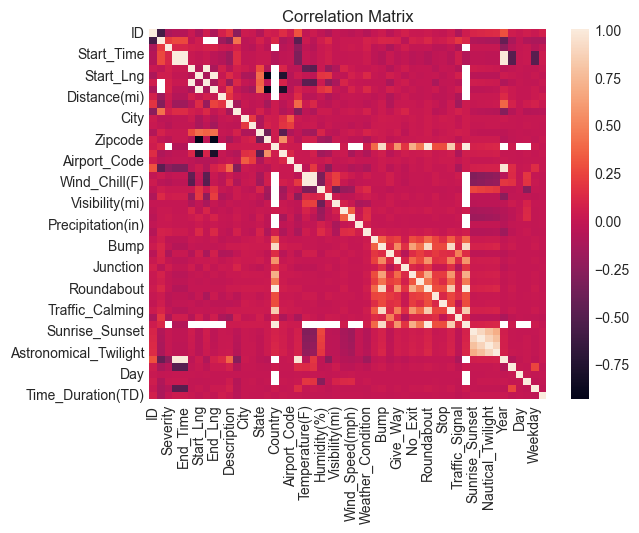

<Figure size 5000x5000 with 0 Axes>

In [33]:
corr_matrix = df.corr()
#List the most highly correlated columns
print(corr_matrix['Severity'].sort_values(ascending=False))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
#Make figure bigger
plt.figure(figsize=(50,50))
plt.show()

Before extracting we need to remove any empty values.

In [36]:
df.dropna(inplace=True)
df.isnull().mean()

ID                       0.0
Source                   0.0
Severity                 0.0
Start_Time               0.0
End_Time                 0.0
Start_Lat                0.0
Start_Lng                0.0
End_Lat                  0.0
End_Lng                  0.0
Distance(mi)             0.0
Description              0.0
Street                   0.0
City                     0.0
County                   0.0
State                    0.0
Zipcode                  0.0
Country                  0.0
Timezone                 0.0
Airport_Code             0.0
Weather_Timestamp        0.0
Temperature(F)           0.0
Wind_Chill(F)            0.0
Humidity(%)              0.0
Pressure(in)             0.0
Visibility(mi)           0.0
Wind_Direction           0.0
Wind_Speed(mph)          0.0
Precipitation(in)        0.0
Weather_Condition        0.0
Amenity                  0.0
Bump                     0.0
Crossing                 0.0
Give_Way                 0.0
Junction                 0.0
No_Exit       

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


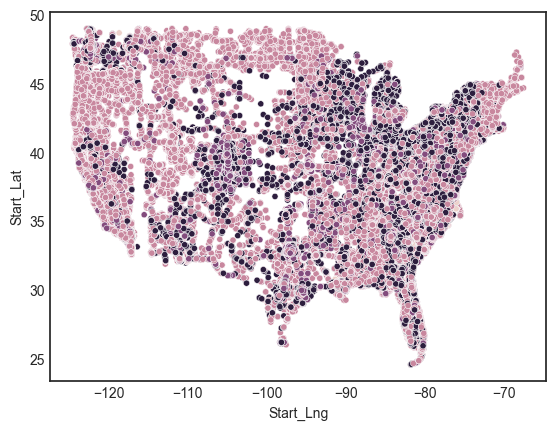

In [54]:
df_extracted = df[['Severity', 'Source', 'Time_Duration(TD)', 'End_Lng', 'End_Lat', 'Street', 'Start_Lat', 'Weather_Condition', 'Start_Lng', 'Junction', 'Pressure(in)', 'Wind_Speed(mph)', 'Distance(mi)', 'Wind_Direction', 'Description', 'Humidity(%)', 'State', 'Precipitation(in)']]     
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_extracted, hue='Severity', legend=False, s=20)
plt.show()

(2308395, 2)


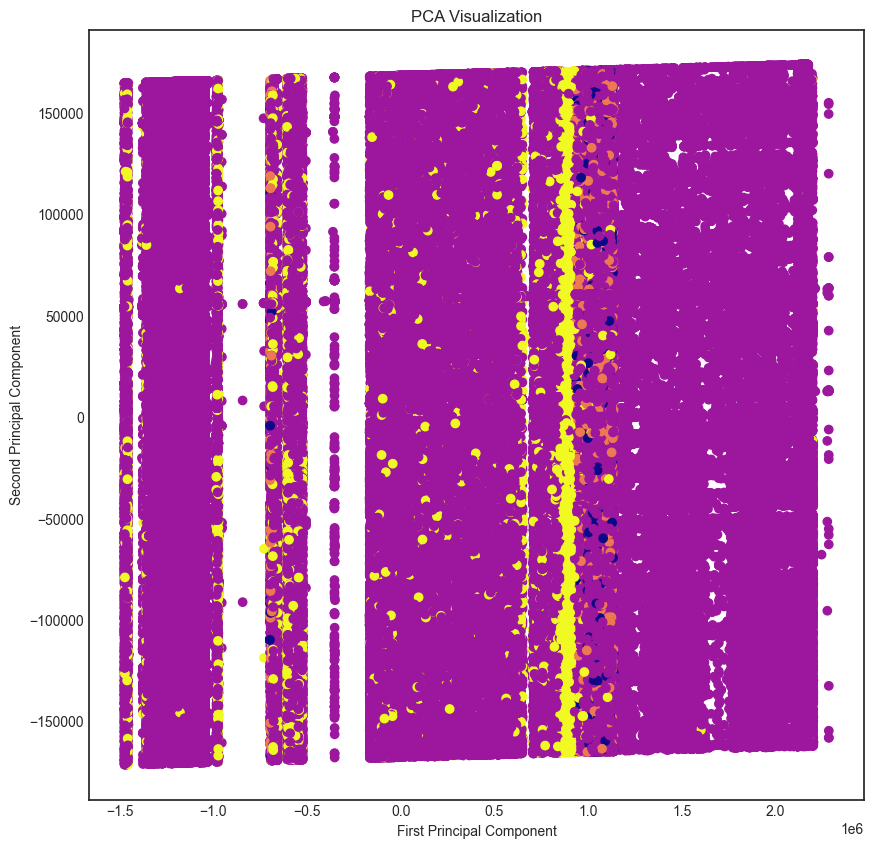

In [55]:
#Split the data into training, testing, and validation sets
X = df_extracted.drop('Severity', axis=1)
y = df_extracted['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
#Apply PCA to the data
#

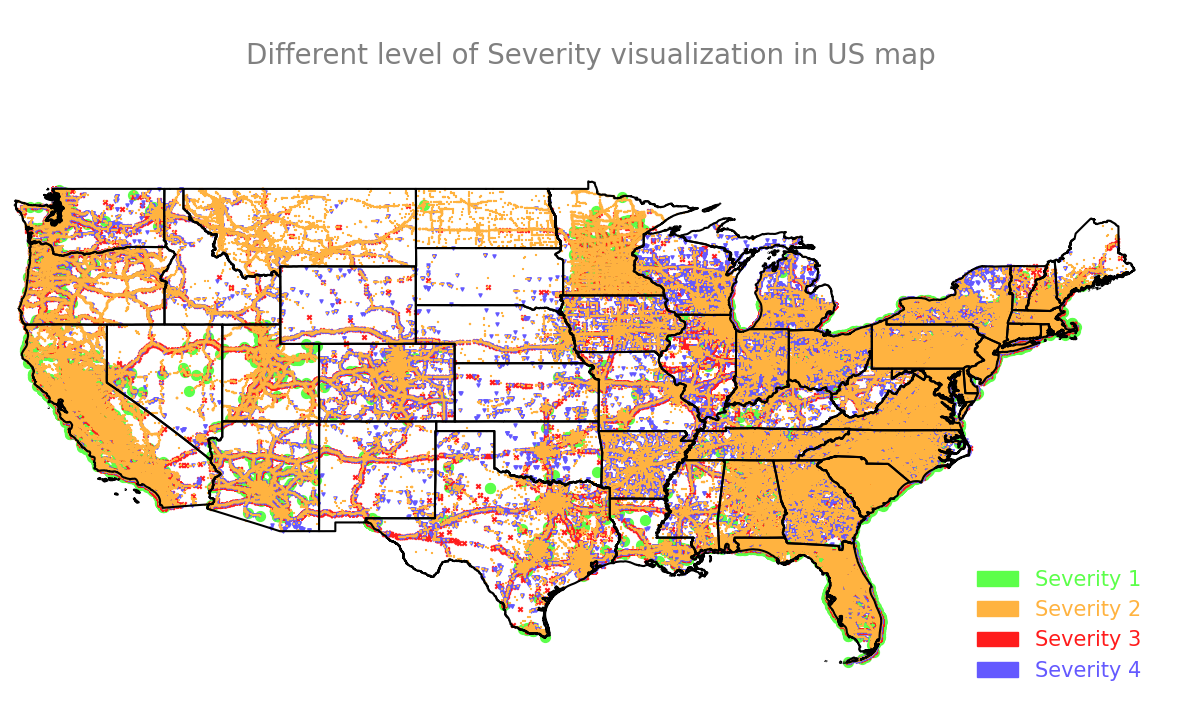

In [14]:
import geopandas as gpd
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from geopy.geocoders import Nominatim
from shapely.geometry import Point
# US States
states = gpd.read_file('cb_2018_us_state_500k.shx')

def lat(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    return (location.latitude)

def lng(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    return (location.longitude)

#Create a map of the US
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='black');

geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=50, color='#5cff4a', marker='o', label='Severity 1');
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=10, color='#ff1c1c', marker='x', label='Severity 3');
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=5, color='#6459ff', marker='v', label='Severity 4');
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=1, color='#ffb340', marker='+', label='Severity 2');

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nDifferent level of Severity visualization in US map', size=20, color='grey');

One = mpatches.Patch(color='#5cff4a', label='Severity 1')
Two = mpatches.Patch(color='#ffb340', label='Severity 2')
Three = mpatches.Patch(color='#ff1c1c', label='Severity 3')
Four = mpatches.Patch(color='#6459ff', label='Severity 4')

ax.legend(handles=[One, Two, Three, Four], prop={'size': 15}, loc='lower right', borderpad=1, 
          labelcolor=['#5cff4a', '#ffb340', '#ff1c1c', '#6459ff'], edgecolor='white');



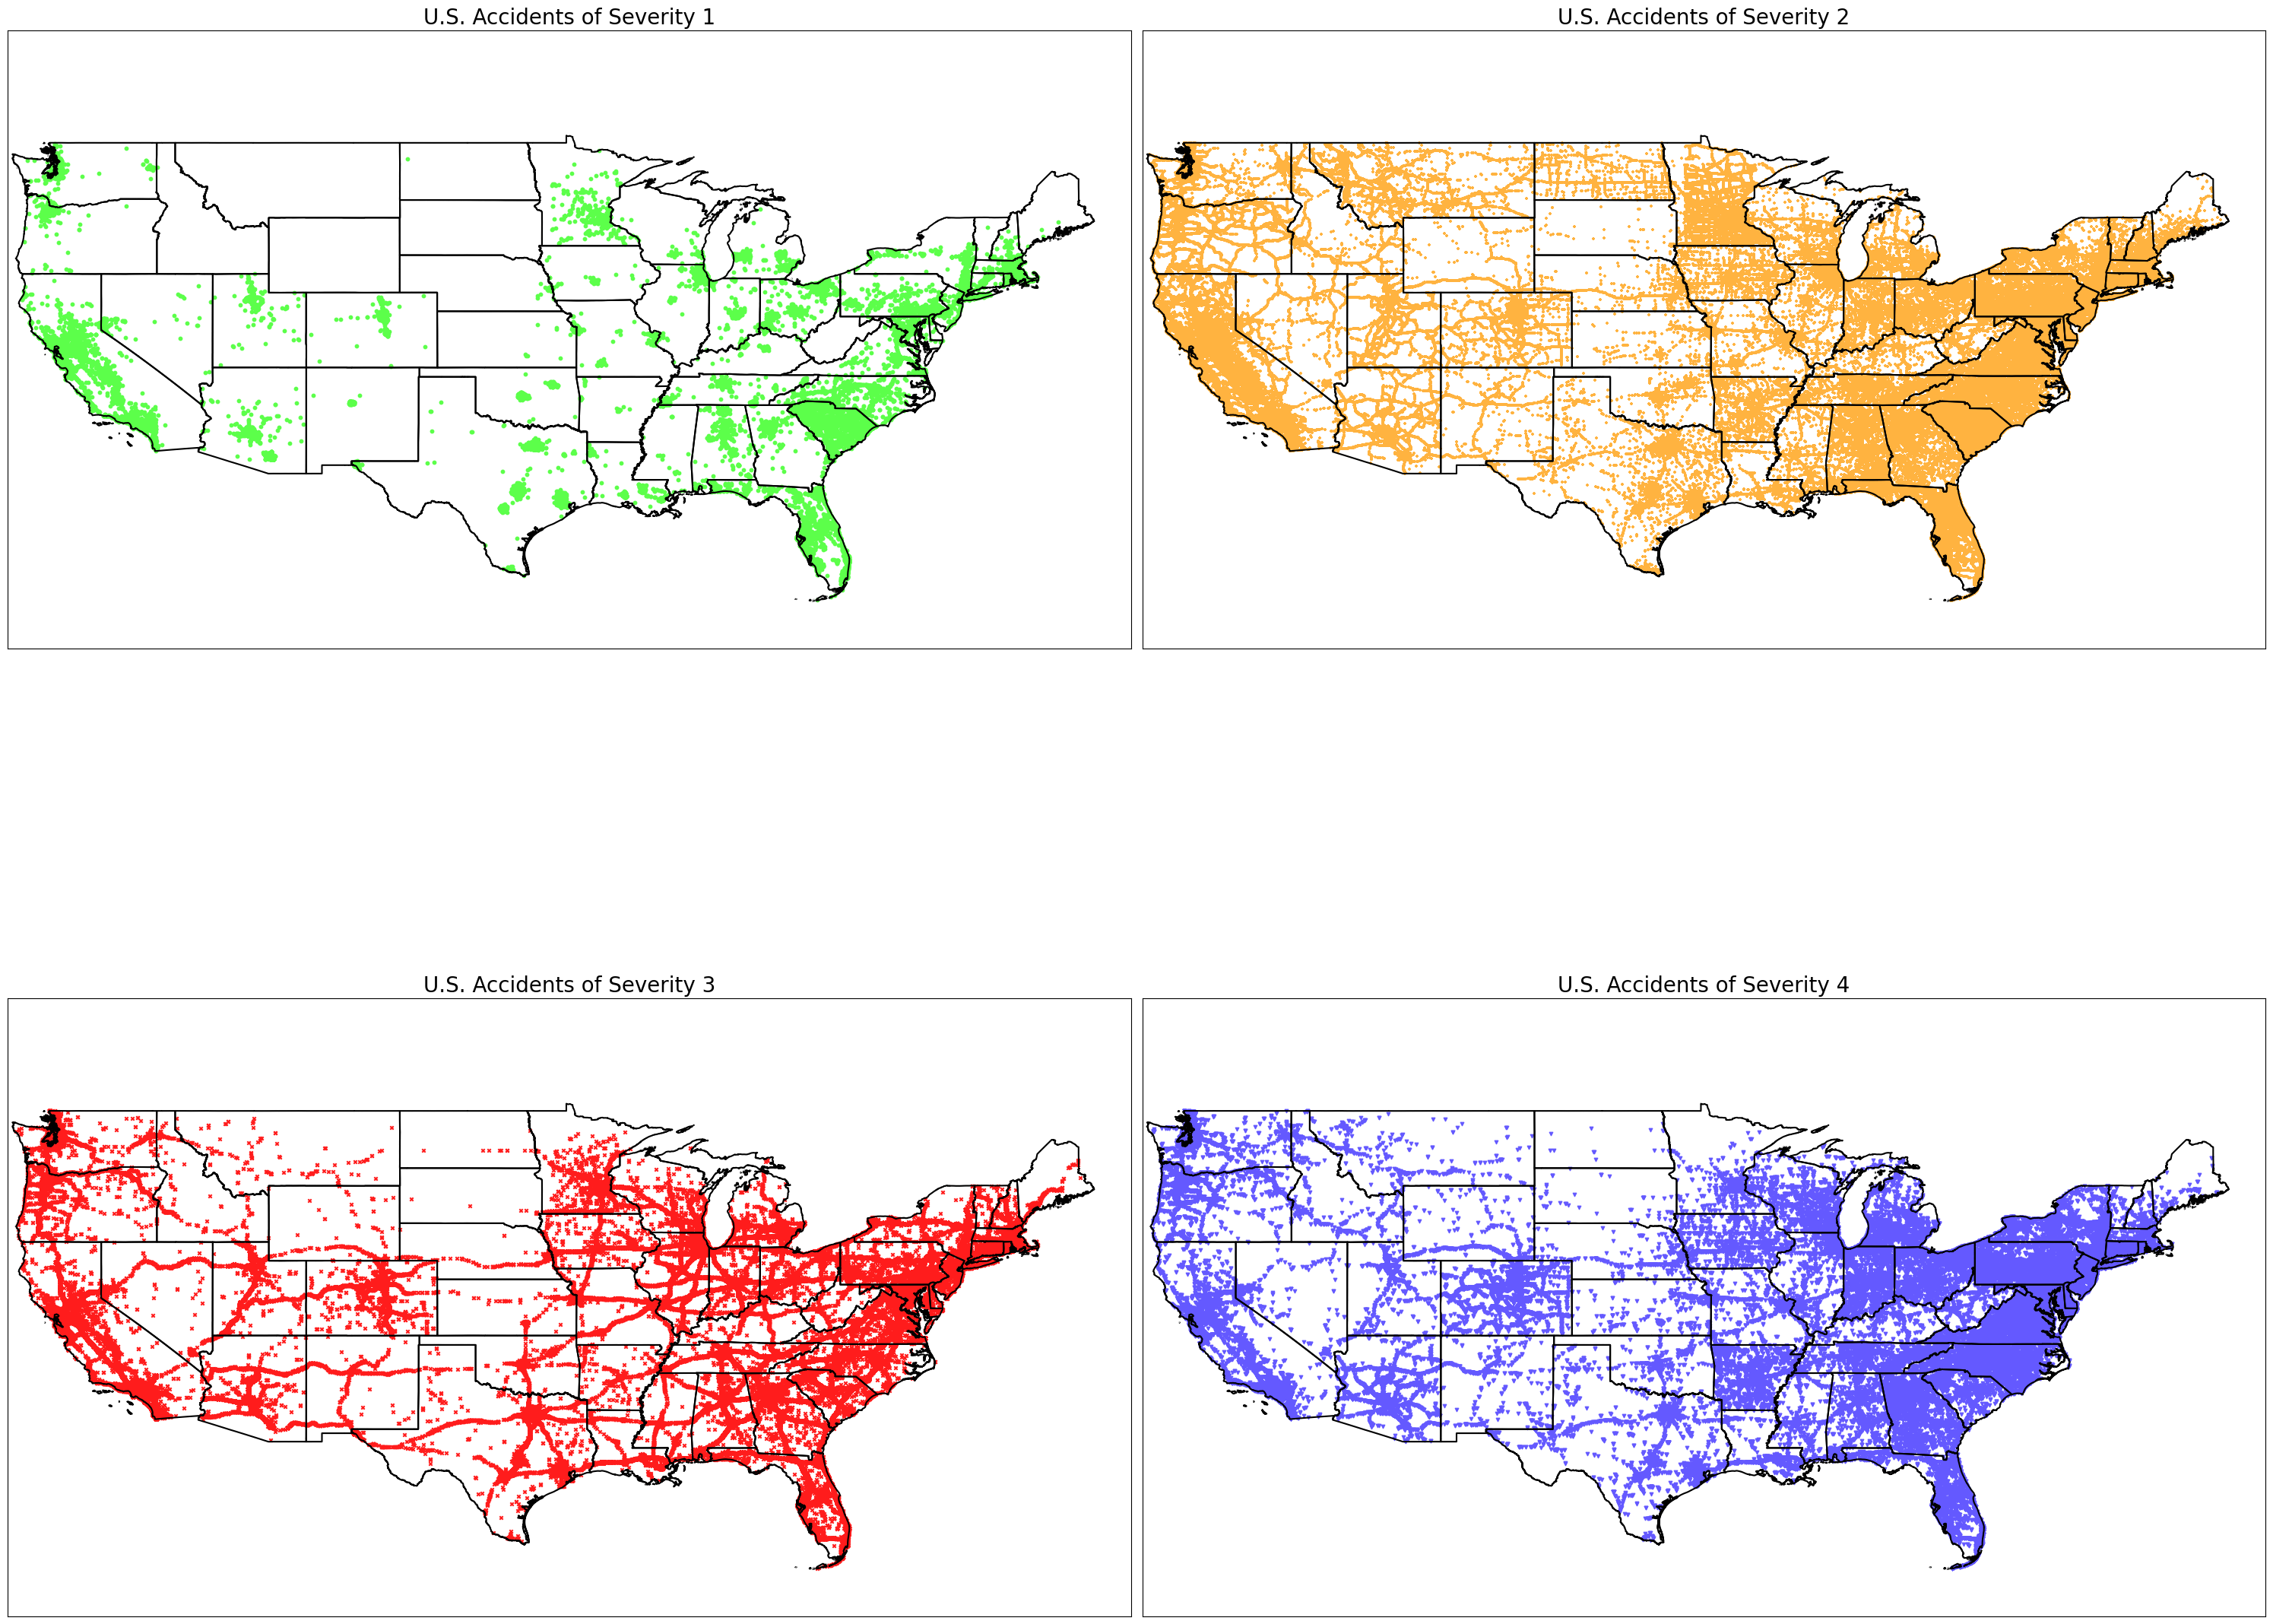

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
states = gpd.read_file('cb_2018_us_state_500k.shx')

#Function to create a map for a given severity
def create_severity_map(severity, color, marker, label, ax):
    geo_df[geo_df['Severity'] == severity].plot(ax=ax, markersize=10, color=color, marker=marker, label=label)

geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

fig, axs = plt.subplots(2, 2, figsize=(30,30))  

#Plot each severity on its own map
create_severity_map(1, '#5cff4a', 'o', 'Severity 1', axs[0, 0])
create_severity_map(2, '#ffb340', '+', 'Severity 2', axs[0, 1])
create_severity_map(3, '#ff1c1c', 'x', 'Severity 3', axs[1, 0])
create_severity_map(4, '#6459ff', 'v', 'Severity 4', axs[1, 1])

for ax in axs.flatten():
    ax.set_xlim([-125, -65])
    ax.set_ylim([22, 55])
    states.boundary.plot(ax=ax, color='black')
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

axs[0, 0].set_title('U.S. Accidents of Severity 1', size=20)
axs[0, 1].set_title('U.S. Accidents of Severity 2', size=20)
axs[1, 0].set_title('U.S. Accidents of Severity 3', size=20)
axs[1, 1].set_title('U.S. Accidents of Severity 4', size=20)
plt.tight_layout()
plt.show()
